This notebook deconstructs the StableDiffusionPipeline.

In [1]:
from PIL import Image

import torch

from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)

tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")

text_encoder = CLIPTextModel.from_pretrained(

    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True

)

unet = UNet2DConditionModel.from_pretrained(

    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True

)

We are allowed to swap schedulers if we want to:

In [2]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

We can move the model to the GPU to speed up inference:

In [3]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
print()

In [4]:
prompt = ["A photo of a magic apple"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
#generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
generator = torch.Generator(device='cuda').manual_seed(0)
batch_size = len(prompt)
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

print("initial text_embeddings shape:", text_embeddings.shape)
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
print("unconditional text embeddings shape:", uncond_embeddings.shape)
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print("final text_embeddings shape:", text_embeddings.shape)

initial text_embeddings shape: torch.Size([1, 77, 768])
unconditional text embeddings shape: torch.Size([1, 77, 768])
final text_embeddings shape: torch.Size([2, 77, 768])


Let's create (latent space) noise.

In [5]:
latents = torch.randn(

    (batch_size, unet.config.in_channels, height // 8, width // 8),

    generator=generator,

    device=torch_device,

)

What do the latents look like?

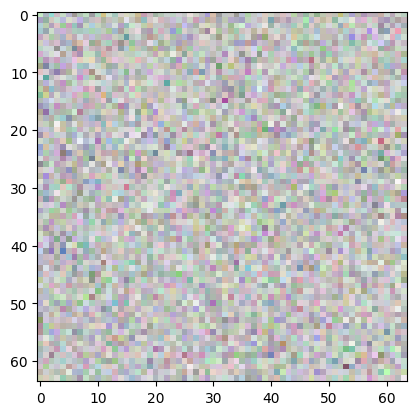

In [6]:
import matplotlib.pyplot as plt

def display(noise):
    # Normalize the tensor
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    
    # Move the tensor to CPU and convert to numpy
    noise_np = noise.squeeze().cpu().numpy()
    
    # Transpose the numpy array to have the color channel as the last dimension
    noise_np = noise_np.transpose(1, 2, 0)
    
    # Display the image
    plt.imshow(noise_np)
    plt.show()

display(latents)

It's noticably lower resolution. This is expected because this noise is for the (low-dimensional) latent space.

In [7]:
print("Latents shape:", latents.shape)

Latents shape: torch.Size([1, 4, 64, 64])


Let's denoise the latents. But first, we need to scale for the scheduler to do its thing well.

In [8]:
latents = torch.randn(

    (batch_size, unet.config.in_channels, height // 8, width // 8),

    generator=generator,

    device=torch_device,

)
latents = latents * scheduler.init_noise_sigma

from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

The latents are still in latent space, so they don't quite look like the image we want to end up with:

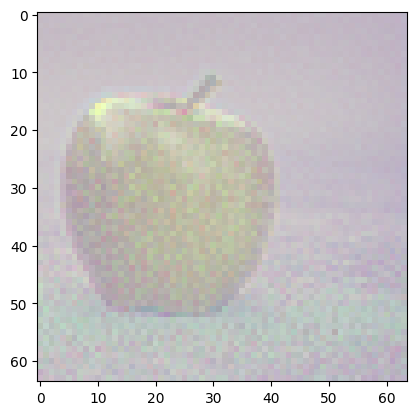

In [9]:
display(latents)

So as a final step, we'll decode the image from the latents.

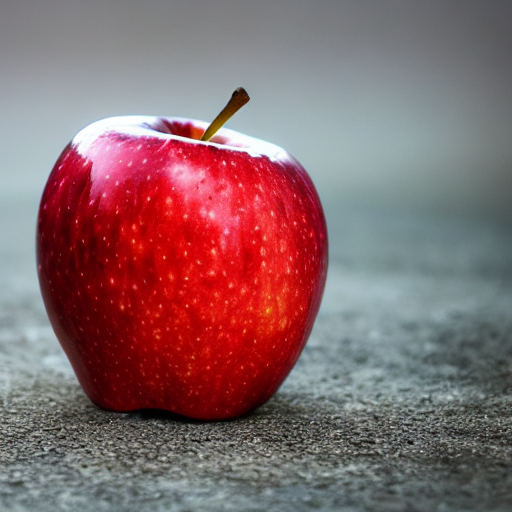

In [10]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1).squeeze()

image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()

images = (image * 255).round().astype("uint8")

image = Image.fromarray(image)

image